# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

> **Note**: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results.

## Overview

This notebook introduces [DANDI:001366 (version 0.250324.1603)](https://dandiarchive.org/dandiset/001366/0.250324.1603), a dataset containing grayscale movies of pial vessels in mice, used for comparing different methods of quantifying vessel diameter and pulsatility. 

The dataset was contributed by researchers from the University of Copenhagen and University of Rochester, with support from the National Institute of Health and United States Army.

This notebook covers:
1. Accessing basic Dandiset metadata
2. Exploring the NWB files in the dataset
3. Examining the structure of the NWB files
4. Visualizing vessel imaging data
5. Demonstrating intensity-based vessel dynamics analysis
6. Creating reusable functions for working with this Dandiset
7. Discussing potential analyses and applications

## Required Packages

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pynwb
import remfile
from dandi.dandiapi import DandiAPIClient
from itertools import islice

## Accessing Dandiset Metadata

In [2]:
# Connect to the DANDI Archive and get the Dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")
metadata = dandiset.get_raw_metadata()

# Display basic metadata
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description']}")
print(f"\nKeywords: {', '.join(metadata['keywords'])}")
print(f"License: {metadata['license']}")

# Print contributor information using a more robust approach
print("\nContributors:")
if 'contributor' in metadata:
    for contrib in metadata['contributor']:
        name = contrib.get('name', 'Unknown')
        roles = ", ".join(contrib.get('roleName', []))
        print(f"- {name} ({roles})")
elif 'contentUrl' in metadata:
    print("- See metadata at: " + metadata['contentUrl'])
else:
    print("- Contributor information not available in this format")

Dandiset name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
Dandiset URL: https://dandiarchive.org/dandiset/001366/0.250324.1603
Description: movies of a pial vessel of mice used in the experiments.

Keywords: full width at half maximum, vessel pulsation, image analysis, vessel diameter, radon transform
License: ['spdx:CC-BY-4.0']

Contributors:
- Zhao, Yue (dcite:Maintainer)
- Ranjan, Aditya (dcite:Author)
- Wong, Devin T. (dcite:Author)
- Huang, Qinwen (dcite:DataCollector)
- Ghanizada, Hashmat (dcite:DataCollector)
- Nedergaard, Maiken  (dcite:ProjectManager)
- Kelley, Douglas H.  (dcite:Supervision)
- Boster, Kimberly A. S. (dcite:ContactPerson, dcite:ProjectManager)
- National Institute of Health (dcite:Funder)
- National Institute of Health (dcite:Funder)
- United States Army (dcite:Funder)


## Exploring NWB Files in the Dandiset

In [3]:
# List all .nwb assets in the dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Display a summary of the files
print(f"Found {len(assets)} NWB files:")
for asset in assets:
    print(f"- {asset.path} ({asset.size/1e6:.2f} MB)")

# Create a summary table for reference
summary_table = []
for asset in assets:
    summary_table.append({
        'filename': asset.path,
        'size_MB': round(asset.size / 1e6, 2)
    })
summary_table

Found 2 NWB files:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb (408.09 MB)
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb (2377.82 MB)


[{'filename': 'sub-F15/sub-F15_ses-F15BC-19102023_image.nwb',
  'size_MB': 408.09},
 {'filename': 'sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb',
  'size_MB': 2377.82}]

## NWB File Structure

Let's examine the structure of the first NWB file to understand the content and organization of the data.

In [4]:
def get_nwb_metadata(nwbfile):
    """Extracts and organizes important metadata from an NWB file."""
    meta_summary = {}

    # Session-level metadata
    meta_summary['session_description'] = nwbfile.session_description
    meta_summary['experiment_description'] = nwbfile.experiment_description
    meta_summary['session_id'] = nwbfile.session_id
    meta_summary['session_start_time'] = str(nwbfile.session_start_time)
    meta_summary['institution'] = nwbfile.institution

    # Subject-level metadata
    subject = nwbfile.subject
    meta_summary['subject_id'] = subject.subject_id
    meta_summary['species'] = subject.species
    meta_summary['sex'] = subject.sex
    meta_summary['age'] = subject.age
    meta_summary['strain'] = getattr(subject, 'strain', None)
    meta_summary['description'] = subject.description

    # Acquisition - Movies metadata
    movies = nwbfile.acquisition['Movies']
    meta_summary['acquisition'] = {
        'name': movies.name,
        'description': movies.description,
        'rate': float(movies.rate),
        'num_frames': movies.data.shape[0],
        'frame_shape': movies.data.shape[1:],
        'dtype': str(movies.data.dtype)
    }
    
    return meta_summary

### Accessing the First NWB File

In [5]:
# Load the first NWB file (the smaller one for faster processing)
nwb_path = 'sub-F15/sub-F15_ses-F15BC-19102023_image.nwb'
asset = next(dandiset.get_assets_by_glob(nwb_path))

# Open the file remotely
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

# Extract metadata
meta_summary = get_nwb_metadata(nwbfile)

# Display metadata in a structured format
print("== NWB File Metadata ==")
print(f"\nSession: {meta_summary['session_description'][:100]}...")
print(f"Experiment: {meta_summary['experiment_description']}")
print(f"Institution: {meta_summary['institution']}")
print(f"Session ID: {meta_summary['session_id']}")
print(f"Start Time: {meta_summary['session_start_time']}")

print("\n== Subject Information ==")
print(f"Subject ID: {meta_summary['subject_id']}")
print(f"Species: {meta_summary['species']}")
print(f"Sex: {meta_summary['sex']}")
print(f"Age: {meta_summary['age']}")
print(f"Strain: {meta_summary['strain']}")
print(f"Description: {meta_summary['description']}")

print("\n== Acquisition (Movies) ==")
acq = meta_summary['acquisition']
print(f"Description: {acq['description']}")
print(f"Frame rate: {acq['rate']} Hz")
print(f"Frames: {acq['num_frames']}")
print(f"Frame shape: {acq['frame_shape']} pixels")
print(f"Data type: {acq['dtype']}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


== NWB File Metadata ==

Session: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with ...
Experiment: Vessel diameter and pulsatility measurement.
Institution: University of Copenhagen
Session ID: F15BC-19102023
Start Time: 2023-10-19 02:00:00-04:00

== Subject Information ==
Subject ID: F15
Species: Mus musculus
Sex: F
Age: P9W/P16W
Strain: C57BL/6J
Description: wild-type mouse

== Acquisition (Movies) ==
Description: 16-bit grayscale movie of a pial vessel
Frame rate: 54.47 Hz
Frames: 9553
Frame shape: (214, 132) pixels
Data type: uint16


### Accessing the Second NWB File 

In [6]:
# Load the second NWB file
nwb_path2 = 'sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb'
asset2 = next(dandiset.get_assets_by_glob(nwb_path2))

# Open the file remotely
remote_file2 = remfile.File(asset2.download_url)
h5_file2 = h5py.File(remote_file2)
io2 = pynwb.NWBHDF5IO(file=h5_file2, load_namespaces=True)
nwbfile2 = io2.read()

# Extract metadata
meta_summary2 = get_nwb_metadata(nwbfile2)

# Display metadata summary focusing on key differences
print("== Second NWB File Key Differences ==")
print(f"\nSubject: {meta_summary2['subject_id']} (vs. {meta_summary['subject_id']})")
print(f"Sex: {meta_summary2['sex']} (vs. {meta_summary['sex']})")
print(f"Age: {meta_summary2['age']} (vs. {meta_summary['age']})")
print(f"Institution: {meta_summary2['institution']} (vs. {meta_summary['institution']})")
print(f"Frame rate: {meta_summary2['acquisition']['rate']} Hz (vs. {meta_summary['acquisition']['rate']} Hz)")
print(f"Frame shape: {meta_summary2['acquisition']['frame_shape']} (vs. {meta_summary['acquisition']['frame_shape']})")
print(f"Total frames: {meta_summary2['acquisition']['num_frames']} (vs. {meta_summary['acquisition']['num_frames']})")

== Second NWB File Key Differences ==

Subject: 031224_M4 (vs. F15)
Sex: M (vs. F)
Age: P2M (vs. P9W/P16W)
Institution: University of Rochester (vs. University of Copenhagen)
Frame rate: 30.0 Hz (vs. 54.47 Hz)
Frame shape: (512, 512) (vs. (214, 132))
Total frames: 6000 (vs. 9553)


## Data Visualization

### Visualizing Movie Frames

Let's visualize sample frames from the movie to better understand the data. We'll display frames evenly spaced throughout the recording.

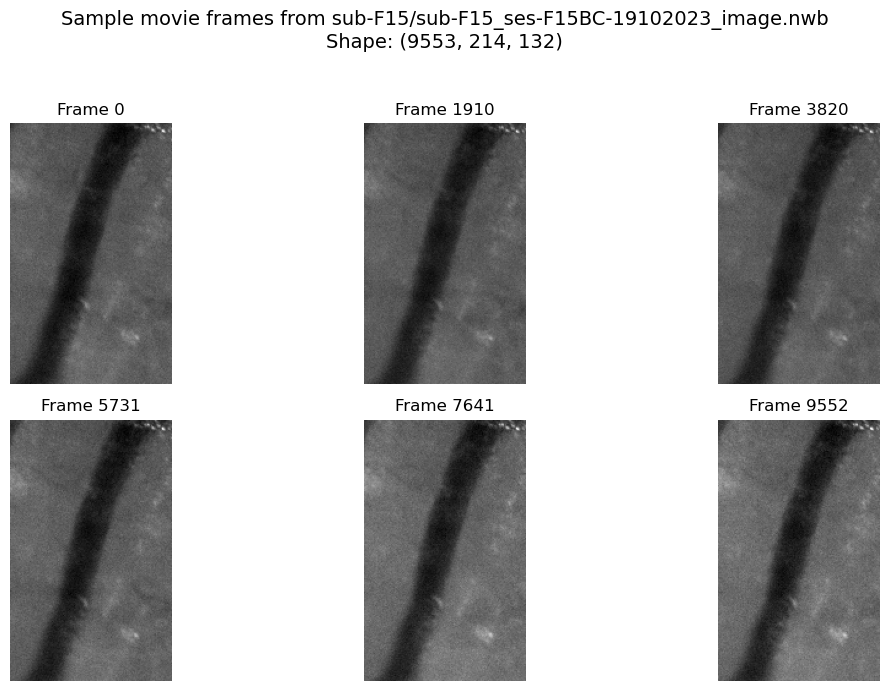

In [7]:
# Access the movie data from the first NWB file
movies = nwbfile.acquisition['Movies']
shape = movies.data.shape  # frames, height, width

# Select evenly spaced frames throughout the movie
example_indices = np.linspace(0, shape[0]-1, 6, dtype=int)
frames = []
for idx in example_indices:
    frame = movies.data[idx, :, :]
    frames.append(frame)

# Plot the frames
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(frames[i], cmap='gray')
    ax.set_title(f'Frame {example_indices[i]}')
    ax.axis('off')
fig.suptitle(f'Sample movie frames from {nwb_path}\nShape: {shape}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The frames above show the vessel throughout the recording. Each image captures a pial vessel (darker region) on a background of brain tissue. This vessel is the target for diameter and pulsatility quantification.

### Vessel Intensity Time Series Analysis

Let's extract a cross-sectional intensity profile along the vessel over time, which serves as a proxy for vessel diameter/pulsation dynamics.

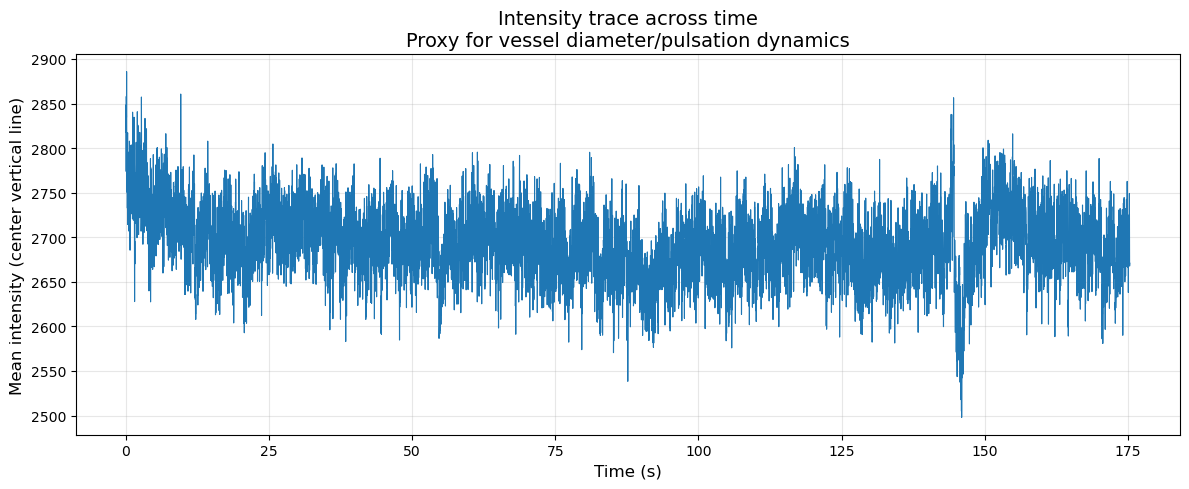

In [8]:
# For illustration, take a vertical line (single pixel column) through the vessel
column = shape[2] // 2  # Center column of the image

# Extract line profile over time at the center column
# (line profile: average intensity across a few rows for stability)
rows = np.arange(shape[1]//2-3, shape[1]//2+3)  # 6-pixel band around center
line_trace = []
for frame_idx in range(shape[0]):
    frame = movies.data[frame_idx, :, :]
    profile = frame[rows, column]
    line_trace.append(np.mean(profile))
line_trace = np.array(line_trace)

# Time vector (frame indices to seconds)
time = np.arange(shape[0]) / movies.rate

# Plot the intensity trace
plt.figure(figsize=(12, 5))
plt.plot(time, line_trace, lw=0.8)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Mean intensity (center vertical line)', fontsize=12)
plt.title('Intensity trace across time\nProxy for vessel diameter/pulsation dynamics', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The plot above shows the time series of mean image intensity along the center vertical line through the vessel. Fluctuations in this trace can reflect changes in vessel diameter and pulsatility. This type of time series is often the foundation for more advanced analyses of vessel dynamics.

## Creating Reusable Functions for Data Access

Let's create a reusable function for loading any NWB file from this Dandiset to facilitate future analyses.

In [9]:
def load_nwb_file(dandiset_id, version, asset_path):
    """
    Load an NWB file from a remote DANDI asset path.
    
    Parameters
    ----------
    dandiset_id : str
        DANDI identifier (e.g., '001366')
    version : str
        Version identifier (e.g., '0.250324.1603')
    asset_path : str
        Path to the NWB file within the Dandiset
        
    Returns
    -------
    nwbfile : pynwb.NWBFile
        The loaded NWB file object
    movies : pynwb.image.ImageSeries
        The Movies ImageSeries from the NWB file
    asset : dandi.dandiapi.Asset
        The DANDI asset object
    """
    client = DandiAPIClient()
    dandiset = client.get_dandiset(dandiset_id, version)
    asset = next(dandiset.get_assets_by_glob(asset_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    movies = nwbfile.acquisition['Movies']
    return nwbfile, movies, asset

# Example usage
print("Example usage of the load_nwb_file function:")
nwb_path = 'sub-F15/sub-F15_ses-F15BC-19102023_image.nwb'
nwbfile, movies, asset = load_nwb_file(
    dandiset_id='001366',
    version='0.250324.1603',
    asset_path=nwb_path
)

# Print summary info
print(f"\nSession: {nwbfile.session_id}")
print(f"Subject: {nwbfile.subject.subject_id}, {nwbfile.subject.species}, Sex: {nwbfile.subject.sex}, Age: {nwbfile.subject.age}")
print(f"Movie shape: {movies.data.shape}, Frame rate: {movies.rate} Hz, Data type: {movies.data.dtype}")

Example usage of the load_nwb_file function:



Session: F15BC-19102023
Subject: F15, Mus musculus, Sex: F, Age: P9W/P16W
Movie shape: (9553, 214, 132), Frame rate: 54.47 Hz, Data type: uint16


## Potential Analyses and Applications

This Dandiset enables several types of analyses:

1. **Vessel Diameter Quantification**
   - Track vessel wall positions frame-by-frame
   - Apply methods like line-profile fitting, edge detection, Radon transform, or full width at half maximum
   - Quantify basal diameter and dynamic changes

2. **Pulsatility and Vascular Dynamics**
   - Extract rhythmic components (heartbeats, respiration, vasomotion)
   - Apply time-series and frequency analysis methods
   - Analyze pulse amplitude and shape characteristics

3. **Comparative Image Analysis**
   - Benchmark different analysis pipelines
   - Evaluate algorithmic accuracy, speed, and sensitivity 
   - Compare the performance of different vessel diameter quantification methods

4. **Morphological Characterization**
   - Study vessel curvature and tortuosity
   - Create spatial-temporal maps of diameter
   - Analyze vessel wall fluctuations

5. **Cross-Subject Comparisons**
   - Compare characteristics between subjects with different metadata (sex, age, etc.)
   - Relate vessel metrics to subject characteristics

The NWB format and DANDI infrastructure make these analyses reproducible and accessible within modern scientific Python workflows.

## Conclusion

This notebook has provided an introduction to Dandiset 001366, demonstrating how to access and visualize vessel imaging data, and presenting possibilities for further analysis. The standardized NWB format, combined with DANDI tools, offers researchers a streamlined path to vessel diameter and pulsatility analysis.